In [23]:
from numpy import eye, linalg, arange, sqrt, diag, sin, pi, linspace, heaviside, sum as npsum, multiply, conjugate, real, array, zeros, copy, var, std
import matplotlib.pyplot as plt

In [24]:
# funcaozinha para inserir o range do eixo x, autovalores, autovetores e o numero de energias desejado na visualização; possivel inserir potencial para plotar junto
def plotEnPsi_finite_diff(x_values, en, psi, n, scale,ymin,ymax,xmin=0, xmax=800, potential=0):
    spot_size=1
    plt.scatter(x_values, potential, c="C1140", s=spot_size)
    for j in range(n):
        plt.hlines(
            en[j],
            xmin=x_values[0],
            xmax=x_values[-1],
            colors="C" + str(j),
            linestyles="--",
        )
        plt.scatter(x_values, en[j] + scale * psi[:, j],  c="C" + str(j), s=spot_size)
        y_min, y_max = (ymin, ymax)
        plt.ylim(y_min, y_max)
        x_min, x_max = (xmin, xmax)
        plt.xlim(x_min, x_max)
    plt.show()

In [25]:
n_2dmu = []

In [26]:
# PARAMETROS DO SISTEMA
h_bar=1 #planck reduzida
m = 0.067 #massa efetiva para GaAs na eq. de Schrödinger
L = 800  # tamanho do sistema
Ry = 26 #eV é a unidade de Energia
a0 = 0.05 #nm é a unidade de distância
h_bar2_m0 = Ry * a0**2
e2 = Ry * a0
k = 13 #constante dielétrica na eq. de Poisson
n2D = 5*10**(-5) #a.u. densidade experimentais

# parametros do poco (GaAs)
xmin_poco = 0.25 * L #a.u. parede do poço
xmax_poco = 0.75 * L #a.u. parede do poço
V_0_poco = 0.01 #a.u. profundidade do poço quadrado

# parametros do tempero
f = 0.1

# parâmetros de convergência
epsilon = 0.0001 

# # dopagem (0 representa o fundo do poço)
# mu = 0.005

# DISCRETIZAÇÃO E INTERVALO ABSCISSAS
M = 100 # Número para ajustar N <IMPORTANTE>
# Mlin = 3*M + 2 #Número para ajustar N <IMPORTANTE>
N= 4*M + 3 #Numero de pontos na rede
dx = L/(N+1)  # discretização> dx = L/N+1 => N = (L/dx) - 1
x = arange(1, N+1)*dx

# parametros iniciais no ciclo de autoconsistência
V_h_inicial = zeros(N)
n_3d_loop = zeros(N)

In [27]:
n_points=100
dmu = 0.0099/n_points  # discretização> dx = L/N+1 => N = (L/dx) - 1
mu_x = arange(1, n_points-1)*dmu + 0.00037
# dopagem (0 representa o fundo do poço)
# mu = mu_x[9] # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
mu_x = mu_x[:70]
# para ver a convergência da energia
enrg_inte_1 = []
enrg_inte_2 = []

In [28]:
# LAPLACIANO 1D DISCRETIZADO
laplaciano = lambda dx,N: -(1 / (dx ** 2)) * (2 * eye(N) - eye(N, k=-1) - eye(N, k=1))
energia_cinetica = lambda m: -(0.5/m)*laplaciano(dx,N)

In [29]:
# DEFINIÇÃO DO POTENCIAL ESTRUTURAL
poco_quadrado_finito = (
    lambda profundidade, xmin, xmax, x: -profundidade
    * heaviside(  # somar profundidade apenas para deixar o fundo do poço = 0
        x - xmin, 1
    )
    * heaviside(xmax - x, 1)
    + profundidade
)   

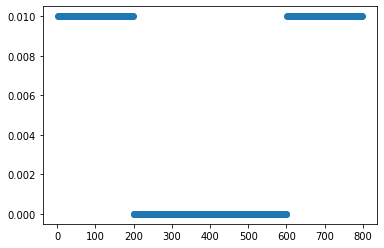

In [30]:
# POTENCIAIS
# scale = 2
V_poco_quadrado_finito = poco_quadrado_finito(
    profundidade=V_0_poco, xmin=xmin_poco, xmax=xmax_poco, x=x
)
def V_hartree(n_3d, k, dx, N, x):
  L=int(dx*(N+1)) 
  V_antes = linalg.solve(laplaciano(dx, N), (-4*pi/k)*n_3d)
  alpha = (V_antes[int((N-3)/4)] - V_antes[int(((3*N)-1)/4)])/(.5*L)
  beta = - V_antes[int((N-3)/4)]
  # x = arange(1, N+1)*dx
  reta_correcao = alpha*(x-(L/4)) + beta
  return V_antes + reta_correcao # V_hartree com as bordas sempre em V=0 !!
  
V_hartree_temperado = lambda tempero, V_1, V_3: f*V_3 + (1-f)*V_1
V_total = lambda V_estrutural, V_interacao: V_estrutural + V_interacao 
plt.scatter(x, V_poco_quadrado_finito)
# plt.xlim(399,401)
plt.show()


In [31]:
# E0_mu (soma de níveis ocupados)
E0_mu = lambda mu, E0_list: npsum(E0_list, where=E0_list<=mu)
# Numero de níveis ocupados 
N_levels = lambda mu, E0_list: npsum(E0_list<=mu)
# D.O.L 3D
def n_3d(phi_list, E0_list, mu, m): 
  vectors = array([(m*(mu-E0_list[j])/(2*pi*(h_bar**2)))*(conjugate(phi_list[j])*phi_list[j]) for j in range(N_levels(mu, E0_list))])
  if N_levels(mu, E0_list) > 1:
    return npsum(vectors, axis=0)
  elif N_levels(mu, E0_list) == 1:
    return vectors[0]
  return zeros(N)
# D.O.L 2D
n_2d_params = lambda mu, m, E0_list: [npsum(E0_list<=mu)*m/(2*pi*(h_bar**2)),-E0_mu(mu, E0_list)*m/(2*pi*(h_bar**2))] #retorna os coeficientes linear e angular, n_2d_params[0]==a e n_2d_params[1]==b

In [32]:
# O HAMILTONIANO
H = lambda V_efetivo, m: energia_cinetica(m) + diag(
    V_efetivo
)

In [33]:
# Primeira vez que foi executado o programa:
V_1 = V_h_inicial
V_3 = V_hartree(n_3d_loop, k, dx, N, x)
V_temperado = V_hartree_temperado(0, V_1, V_3)
V_efetivo = V_total(V_poco_quadrado_finito, V_temperado)
# diagonalização
E0_list, phi_list = linalg.eigh(H(V_efetivo, m))
E0_poco = copy(E0_list)
lista_N_ocupados = []
lista_energias = []
for mu in mu_x:
    N_ocupados = N_levels(mu, E0_poco)
    print("Numero de niveis ocupados antes do loop", N_ocupados)
    # print("Energias ocupadas antes do loop", E0_poco[:N_ocupados])

    # teste de consistência para ver as energias do poço
    # plotEnPsi_finite_diff(x, E0_poco, phi_list, N_ocupados, 0.05,0, 0.02, V_efetivo)

    n_3d_loop = n_3d(phi_list, E0_poco, mu, m)
    n_2d_loop = n_2d_params(mu, m, E0_poco)
    # print("formato n3d antes loop =>", n_3d_loop.shape)
    # obtendo energias e estados
    # E0, phi_list = linalg.eigh(H)

    # Loop de autoconsistência:
    convergiu = False
    cont_inte = []
    n_2d_converg = [copy(n_2d_loop)]
    iteracao = 1
    while not convergiu:
        # print("iter=", iteracao)
        cont_inte.append(
            iteracao
        )  #                       Pegando o cont_inte <------- aqui
        V_3 = V_hartree(n_3d_loop, k, dx, N, x)
        V_temperado = V_hartree_temperado(f, V_temperado, V_3)
        V_efetivo = V_total(V_poco_quadrado_finito, V_temperado)
        # diagonalização
        E0_list, phi_list = linalg.eigh(H(V_efetivo, m))
        N_ocupados = N_levels(mu, E0_list)
        print("N_ocupados no loop", N_ocupados)
        enrg_inte_1.append(E0_list[0])  # Pegando o enrg_inte <------- aqui
        enrg_inte_2.append(E0_list[1])  # Pegando o enrg_inte <------- aqui
        n_3d_loop_novo = n_3d(phi_list, E0_list, mu, m)
        # print("n_3d_loop_novo", n_3d_loop_novo)
        # n_3d_loop_novo = n_3d_loop_novo if n_3d_loop_novo.size != N else zeros(N)
        n_2d_loop_novo = n_2d_params(mu, m, E0_list)
        n_2d_converg.append(copy(n_2d_loop_novo))
        # teste convergencia STD!!
        if (iteracao >= 30):
            desvio = std(n_2d_converg[-30:], axis=0)
            # print("desvio =", desvio)
            if (desvio[0] < epsilon) and (desvio[1] < epsilon):
                # print("convergiu!")
                # print("Numero de niveis ocupados", N_ocupados)
                # print("Energias ocupadas", E0_list[:N_ocupados])
                n_2dmu.append(n_2d_loop_novo)
                lista_energias.append(E0_mu(mu, E0_list))
                lista_N_ocupados.append(N_levels(mu, E0_list))
                convergiu = True
        # if (abs((n_2d_loop_novo[0] - n_2d_loop[0])/n_2d_loop[0])<epsilon) and (abs((n_2d_loop_novo[1] - n_2d_loop[1])/n_2d_loop[1])<epsilon):
        #   # se convergiu
        #     print("Numero de niveis ocupados", N_ocupados)
        #     print("Energias ocupadas", E0_list[:N_ocupados])
        #     print("convergiu!")
        #     n_2dmu.append(n_2d_loop_novo)
        #     lista_energias.append(E0_mu(mu, E0_list))
        #     lista_N_ocupados.append(N_levels(mu, E0_list))
        #     convergiu = True
        else:
            # se nao convergiu
            # print("formato V_1 novo", V_1.shape)
            n_2d_loop = copy(n_2d_loop_novo)
            n_3d_loop = copy(n_3d_loop_novo)
            iteracao += 1


Numero de niveis ocupados antes do loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
Numero de niveis ocupados antes do loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no loop 1
N_ocupados no

In [ ]:
plotEnPsi_finite_diff(x, E0_list, phi_list, N_ocupados, 0.03, -0.0001, 0.006, 0, 800, V_efetivo)

In [ ]:
cont_inte = array(cont_inte)
enrg_inte_1 = array(enrg_inte_1)
# print(enrg_inte_1)
enrg_inte_2 = array(enrg_inte_2)

plt.plot(cont_inte, enrg_inte_1[-len(cont_inte):], color='blue')
plt.plot(cont_inte, enrg_inte_2[-len(cont_inte):], color='red')
plt.xlabel("interações")
plt.ylabel("Energia")
plt.show()

In [ ]:
n_2d_y = []
print(len(n_2dmu))
for i in range(len(mu_x)):
    f = n_2dmu[i][0]*mu_x[i] + n_2dmu[i][1]
    n_2d_y.append(f)
n_2d_y = array(n_2d_y)

In [ ]:
plt.hist(lista_energias,bins=200)
plt.show()

In [ ]:
plt.scatter(mu_x, n_2d_y, s=1, linestyle="dashed", label="densidade 2D")
# for E0 in E0_poco[:3]:
#   plt.vlines(E0,0, 0.0001, colors=["black"], label="Energias Poço Sem Interação")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$n_{2D}$')
plt.ylim(0,0.00005)
plt.legend(loc="best")
plt.show()

In [ ]:
plt.scatter(mu_x, lista_N_ocupados,s=1, label="ocupacao")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$N$')
plt.legend(loc="best")
plt.ylim(0,4)
plt.show()

In [ ]:
plt.scatter(mu_x, lista_energias, s=1, label="energia GS")
plt.xlabel(r'$\mu$')
plt.ylabel(r'$E_{GS}$')
plt.legend(loc="best")
plt.ylim(0,0.01)
plt.show()